# Full pipeline: batch cross validation

The first two notebooks looked at Canny edge detection and the Hough transform for line detection. Those notebooks developed functions that we import and use in this notebook to tune parameters from both methods on a batch of images.


In [0]:
!pip install bezier
import bezier
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import glob, os
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

# Import data

Not all the images have lane markings. However, this can be determined by looking at the annotation files.

In [0]:
wdir='/content/drive/My Drive/ece1512/homework/3/'

In [0]:
wildcard=wdir+'bdd100k/images/10k/train/*.jpg'
files = set([f.split('/')[-1] for f in glob.glob(wildcard)])
len(files)


7000

In [0]:
fname = wdir+'/bdd100k/labels/bdd100k_labels_images_train.json'
batch_size=1000
with open(fname) as f:
    data100k = json.load(f)
    data100k_train = data100k[:batch_size] # train batch
    data100k_test = data100k[batch_size*2:batch_size*3] # train batch
    data100k_val = data100k[batch_size*3:batch_size*4] # train batch


data10k_train = [example for example in data100k_train 
                 if example['name'] in files]
data10k_test = [example for example in data100k_test 
                if example['name'] in files]
data10k_val = [example for example in data100k_val 
               if example['name'] in files]



In [0]:
def get_lanes(data10k):
  data10k_lanes = []
  for example in data10k:
    lanes = [o for o in example['labels']
                    if 'poly2d' in o and o['category'][:4] == 'lane']
    if len(lanes) != 0:
      data10k_lanes.append(example)
  return(data10k_lanes)

In [0]:
data10k_train_lanes = get_lanes(data10k_train)
len(data10k_train_lanes)

34

The code developed in the previous notebooks has been refactored. This is availalbe on my [lane_detector](https://github.com/geoffwoollard/lane_detector) github repo

In [0]:
%cd /content/drive/My Drive/ece1512/homework/3/lane_detector
from lane_detector import boxes_from_gtlanes, \
  pred_lines_to_boxes, boxes_to_bool2d, evaluate

/content/drive/My Drive/ece1512/homework/3/lane_detector


In [0]:
def comp_iou_wrapper(data,
                     image_dir =  wdir+'bdd100k/images/10k/train/',
                     gaussian_filter_sigma=1.7,
                     canny_min_threshold=50,
                     canny_max_threshold=150,
                     canny_aperture_size=3,
                     canny_L2_gradient=False,
                     
                     hough_rho=1,
                     hough_theta=np.pi/180., 
                     hough_threshold=100,
                     hough_min_line_length=75,
                     hough_max_line_gap=50, 
                     
                     evaluation_method='bezier',
                     evaluation_box_diag=50
                    ):
  r = np.arange(0)
  c = np.arange(0)
  iou_d={}
  for example in data:
    fname = image_dir+example['name']
    if example['name'] not in files:
      iou_d[example['name']] = np.nan
      continue
    lanes = [o for o in example['labels']
                  if 'poly2d' in o and o['category'][:4] == 'lane']
    if len(lanes) == 0:
      iou_d[example['name']] = np.nan
      continue

    assert os.path.isfile(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if gray.shape[0] != r.size: r = np.arange(gray.shape[0])
    if gray.shape[1] != c.size: c = np.arange(gray.shape[1])
    smooth = gaussian_filter(gray,sigma=gaussian_filter_sigma)

    edges = cv2.Canny(smooth,
                      threshold1=canny_min_threshold, 
                      threshold2=canny_max_threshold,
                      apertureSize=canny_aperture_size,
                      L2gradient=canny_L2_gradient) 
    '''https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/
    py_imgproc/py_canny/py_canny.html?highlight=canny'''
    
    lines = cv2.HoughLinesP(image=edges,
                          rho=hough_rho, 
                          theta=hough_theta,
                          threshold=hough_threshold,
                          minLineLength=hough_min_line_length,
                          maxLineGap=hough_max_line_gap
                         )
    if lines is None:
      iou_d[example['name']] = 0
      continue

    gt_boxes = boxes_from_gtlanes(lanes,
                                  method=evaluation_method,
                                  box_diag=evaluation_box_diag)
    pred_boxes = pred_lines_to_boxes(lines,
                                     method=evaluation_method,
                                     box_diag=evaluation_box_diag)
    pred_box_2d = boxes_to_bool2d(pred_boxes,r,c)
    gt_box_2d = boxes_to_bool2d(gt_boxes,r,c)
    iou = evaluate(gt_box_2d,pred_box_2d)
    iou_d[example['name']] = iou
    if len(data) == 1:
      iou_d['img'] = img
      iou_d['gray'] = gray
      iou_d['smooth'] = smooth
      iou_d['edges'] = edges
      iou_d['pred_box_2d'] = pred_box_2d
      iou_d['gt_box_2d'] = gt_box_2d
    
  return(iou_d)


In [0]:
iou_d = comp_iou_wrapper(data10k_lanes[:20],
                     gaussian_filter_sigma=1.7,
                     canny_min_threshold=50,
                     canny_max_threshold=150,
                     canny_aperture_size=3,
                     canny_L2_gradient=False,
                     
                     hough_rho=1,
                     hough_theta=np.pi/180., 
                     hough_threshold=150,
                     hough_min_line_length=75,
                     hough_max_line_gap=50,
                     
                     evaluation_method='bezier',
                     evaluation_box_diag=50
                    )

# Grid search hyperparams
This search can become computationally expensive, so it is important to not recompute things uneccesarily. I have refactored and pulled out of the loop functions that can be.

In [0]:
def comp_iou_wrapper_benchmark(data,
                     image_dir =  wdir+'bdd100k/images/10k/train/',
                     gaussian_filter_sigma_list=None,
                     canny_d_list=None,
                     hough_d_list=None,# 1 or 2. artefacts appearing for 3,4
                     evaluation_d_list=None
                    ):
  r = np.arange(0)
  c = np.arange(0)
  iou_d_list=[]
  for example in data:
    iou_d={}
    fname = image_dir+example['name']
    iou_d = iou_d.copy()
    iou_d['name'] = example['name']

    lanes = [o for o in example['labels']
                  if 'poly2d' in o and o['category'][:4] == 'lane']
    if len(lanes) == 0:
      iou_d['iou'] = np.nan
      iou_d_list.append(iou_d)
      continue

    assert os.path.isfile(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if gray.shape[0] != r.size: r = np.arange(gray.shape[0])
    if gray.shape[1] != c.size: c = np.arange(gray.shape[1])
    for gaussian_filter_sigma in gaussian_filter_sigma_list:
      iou_d = iou_d.copy()
      iou_d['gaussian_filter_sigma'] = gaussian_filter_sigma
      smooth = gaussian_filter(gray,sigma=gaussian_filter_sigma)
      

      for canny_d in canny_d_list:
        iou_d = iou_d.copy()
        iou_d.update(canny_d)
        edges = cv2.Canny(smooth,threshold1=canny_d['canny_min_threshold'], 
                          threshold2=canny_d['canny_max_threshold'],
                          apertureSize=canny_d['canny_aperture_size'],
                          L2gradient=canny_d['canny_L2_gradient']) 
        '''https://opencv-python-tutroals.readthedocs.io/en/latest/
        py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=canny'''
        
        for hough_d in hough_d_list:
          iou_d = iou_d.copy()
          iou_d.update(hough_d)
          lines = cv2.HoughLinesP(image=edges,
                                rho=hough_d['hough_rho'], 
                                theta=hough_d['hough_theta'],
                                threshold=hough_d['hough_threshold'],
                                minLineLength=hough_d['hough_min_line_length'],
                                maxLineGap=hough_d['hough_max_line_gap']
                               )
          if lines is None:
            iou_d = iou_d.copy()
            iou_d['iou'] = np.nan
            iou_d_list.append(iou_d)
            continue

          lanes = [o for o in example['labels']
                        if 'poly2d' in o and o['category'][:4] == 'lane']

          for evaluation_d in evaluation_d_list:
            iou_d = iou_d.copy()
            iou_d.update(evaluation_d)
            gt_boxes = boxes_from_gtlanes(
                lanes,
                method=evaluation_d['evaluation_method'],
                box_diag=evaluation_d['evaluation_box_diag'])
            pred_boxes = pred_lines_to_boxes(
                lines,
                method=evaluation_d['evaluation_method'],
                box_diag=evaluation_d['evaluation_box_diag'])
            pred_box_2d = boxes_to_bool2d(pred_boxes,r,c)
            gt_box_2d = boxes_to_bool2d(gt_boxes,r,c,)
            iou = evaluate(gt_box_2d,pred_box_2d)
            iou_d['iou'] = iou
            iou_d_list.append(iou_d)
            
            if evaluation_d['evaluation_method'] is None:
              continue
              
            

  return(iou_d_list)


Given the way I coded `comp_iou_wrapper_benchmark`, I need to make dictionaries of parameters to be fed in. 

I will first tune parameters in sets, given by the dictionaries, and then look at how they play together.

In [0]:
canny_d_list=[]
for canny_min_threshold in [50,75]:
  for canny_max_threshold in [150,200]:
    for canny_aperture_size in [3]:
      for canny_L2_gradient in [False]:
        canny_d={}
        canny_d['canny_min_threshold']=canny_min_threshold
        canny_d['canny_max_threshold']=canny_max_threshold
        canny_d['canny_aperture_size']=canny_aperture_size
        canny_d['canny_L2_gradient']=canny_L2_gradient
        canny_d_list.append(canny_d)
len(canny_d_list)  

4

In [0]:
hough_d_list=[]
for hough_rho in [1]:
  for hough_theta in [1]:
    for hough_threshold in [100,150,175]:
      for hough_min_line_length in [50,75,100]:
        for hough_max_line_gap in [50,75]:
          hough_d={}
          hough_d['hough_rho']=hough_rho
          hough_d['hough_theta']=hough_theta*np.pi/180.
          hough_d['hough_threshold']=hough_threshold
          hough_d['hough_min_line_length']=hough_min_line_length
          hough_d['hough_max_line_gap']=hough_max_line_gap
          hough_d_list.append(hough_d)
len(hough_d_list)  

18

In [0]:
evaluation_d_list=[]
for evaluation_method in ['bezier']:
  for evaluation_box_diag in [50]:
          evaluation_d={}
          evaluation_d['evaluation_method']=evaluation_method
          evaluation_d['evaluation_box_diag']=evaluation_box_diag
          evaluation_d_list.append(evaluation_d)
len(evaluation_d_list)

1

In [0]:
%%time
iou_d_list = comp_iou_wrapper_benchmark(data10k,
   image_dir =  wdir+'bdd100k/images/10k/train/',
   gaussian_filter_sigma_list=[1],
   canny_d_list=canny_d_list,
   hough_d_list=[{'hough_rho':1,'hough_theta':np.pi/180.,'hough_threshold':100,
                  'hough_min_line_length':75,'hough_max_line_gap':50}],
   evaluation_d_list=[{'evaluation_method':'bezier','evaluation_box_diag':50}]
  )
pd.DataFrame(iou_d_list).to_csv(wdir+'canny.csv',index=False, sep='\t')

In [0]:
%%time
iou_d_list = comp_iou_wrapper_benchmark(data10k,
   image_dir = wdir+'bdd100k/images/10k/train/',
   gaussian_filter_sigma_list=[1],
   canny_d_list=[{'canny_min_threshold':50,'canny_max_threshold':150,
                  'canny_aperture_size':3,'canny_L2_gradient':False}],
   hough_d_list=hough_d_list,
   evaluation_d_list=[{'evaluation_method':'bezier','evaluation_box_diag':50}]
  )
pd.DataFrame(iou_d_list).to_csv(wdir+'hough.csv',index=False, sep='\t')

In [0]:
%%time
iou_d_list = comp_iou_wrapper_benchmark(data10k,
   image_dir =  wdir+'bdd100k/images/10k/train/',
   gaussian_filter_sigma_list=[1],
   canny_d_list=[{'canny_min_threshold':50,'canny_max_threshold':150,
                  'canny_aperture_size':3,'canny_L2_gradient':False}],
   hough_d_list=[{'hough_rho':1,'hough_theta':np.pi/180.,'hough_threshold':100,
                  'hough_min_line_length':75,'hough_max_line_gap':50}],
   evaluation_d_list=evaluation_d_list
  )
pd.DataFrame(iou_d_list).to_csv(wdir+'eval.csv',index=False, sep='\t')

In [0]:
%%time
iou_d_list = comp_iou_wrapper_benchmark(data10k,
   image_dir =  wdir+'bdd100k/images/10k/train/',
   gaussian_filter_sigma_list=[1,1.5,2,2.5,3,3.5,4],
   canny_d_list=[{'canny_min_threshold':50,'canny_max_threshold':150,
                  'canny_aperture_size':3,'canny_L2_gradient':False}],
   hough_d_list=[{'hough_rho':1,'hough_theta':np.pi/180.,'hough_threshold':100,
                  'hough_min_line_length':75,'hough_max_line_gap':50}],
   evaluation_d_list=[{'evaluation_method':'bezier','evaluation_box_diag':50}]
  )
pd.DataFrame(iou_d_list).to_csv(wdir+'sigma.csv',index=False, sep='\t')

In [0]:
%%time
iou_d_list = comp_iou_wrapper_benchmark(data10k_train_lanes[:5],
                     image_dir = wdir+'bdd100k/images/10k/train/',
                     gaussian_filter_sigma_list=[1,1.5],
                     canny_d_list=canny_d_list,
                     hough_d_list=hough_d_list,
                     evaluation_d_list=evaluation_d_list
                    )
pd.DataFrame(iou_d_list).to_csv(wdir+'train_combo144.csv',index=False, sep='\t')

In [0]:
len(iou_d_list)

## Grid search run time

It takes hours to do grid searches of tens of conditions on tens of images.
I: Number of images  
S: Number of params for smoothing  
C: Number of params for  Canny edge detection  
H: Number of params for Hough Transform  
E: Number of params for Evaluation  
T: Time  

|images|S|C|H|E|T |
|-|-|-|-|-|
|10|1|1|1|1|2.6s|
|38|1|1|1|1|8.9s|
|38|3|1|1|1|32s|
|38|1|9|1|1|25m|
|38|7|1|1|1|11m|
|38|1|1|36|1|63m|
|38|1|1|1|6|25m|
|5|2|4|18|1|97m|

# Param grid search results


In [0]:
import pandas as pd
import glob
df_list = []
for fname in glob.glob(wdir+'*.csv'):
  df_list.append(pd.read_csv(fname,sep='\t'))
df = pd.concat(df_list)


We can look at which conditions gave the best mean IoU over our "training images". The table below is ranked by mean IoU

In [0]:
params = list(set(df.columns) - set(['iou','name']))
grid_results = df.groupby(params).mean()['iou'].sort_values(
    ascending=False).to_frame()


In [0]:
grid_results.head(5).T

hough_min_line_length,75.0,50.0,100.0,75.0,50.0
canny_L2_gradient,False,False,False,False,False
canny_aperture_size,3.0,3.0,3.0,3.0,3.0
hough_max_line_gap,50.0,50.0,50.0,75.0,75.0
evaluation_method,bezier,bezier,bezier,bezier,bezier
gaussian_filter_sigma,1.5,1.5,1.5,1.5,1.5
hough_theta,0.017453,0.017453,0.017453,0.017453,0.017453
evaluation_box_diag,50.0,50.0,50.0,50.0,50.0
canny_min_threshold,75.0,75.0,75.0,75.0,75.0
hough_rho,1.0,1.0,1.0,1.0,1.0
canny_max_threshold,150.0,150.0,150.0,150.0,150.0


## Some conclusions:  
1. most best performing value for the gaussian filters are `1-1.5`, and not 2 or higher.  
2. a larger evaluation box sized of `75` for a thicker line is promosing  

The best combinations of the parameters `hough_threshold`, `hough_max_line_gap`, `hough_min_line_length`, `canny_min_threshold` are less clear, but we use the top few combinations on a validation set of images and use visual inspection.

In [0]:
data10k_lanes_train = get_lanes(data10k_train)
data10k_lanes_val = get_lanes(data10k_val)

len(data10k_lanes_train),len(data10k_lanes_val)

(34, 42)

In [0]:
%%time
iou_d_list = comp_iou_wrapper_benchmark(data10k_lanes_val,
   image_dir =  wdir+'bdd100k/images/10k/train/',
   gaussian_filter_sigma_list=[1],
   canny_d_list=[{'canny_min_threshold':50,'canny_max_threshold':150,
                  'canny_aperture_size':3,'canny_L2_gradient':False}],
   hough_d_list=[{'hough_rho':1,'hough_theta':np.pi/180.,'hough_threshold':100,
                  'hough_min_line_length':75,'hough_max_line_gap':50}],
   evaluation_d_list=[{'evaluation_method':'bezier','evaluation_box_diag':50}]
  )
pd.DataFrame(iou_d_list).to_csv(wdir+'val.csv',index=False, sep='\t')

## Testing by visual inspection

We can compare the predicted images in the testing set side by side with the ground truth. Below we do this for several images and several parameter sets that performed well on the training set. In practice this could be scaled up. It would take under a minute to look at one hundred images. For 10x10 blocks of images could be output with different parameter sets and compared to other 10x10 blocks. 

negative dimensions are not allowed . thick method failed
negative dimensions are not allowed . thick method failed
negative dimensions are not allowed . thick method failed


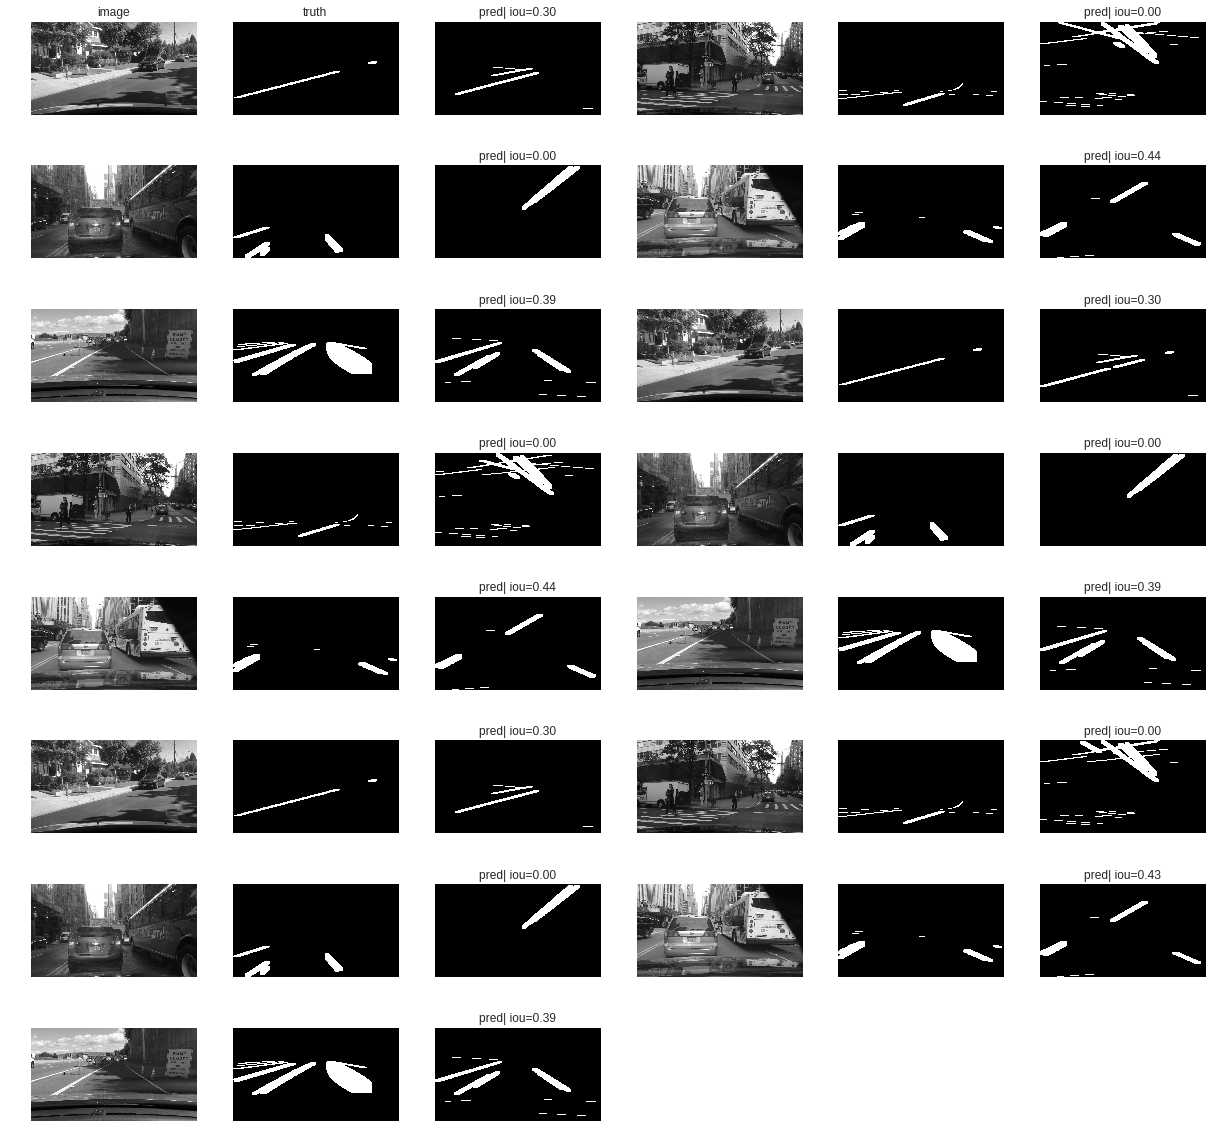

In [45]:
fig = plt.figure(figsize=(17,30))

npics=5
nparams=3
i=1
ncol=6
iou_d={}
for best_params in grid_results.reset_index().to_dict('records')[:nparams]:
  for example in data10k_lanes_train[:npics]:
    iou_d = iou_d.copy()
    iou_d = comp_iou_wrapper(
              [example],
              gaussian_filter_sigma=best_params['gaussian_filter_sigma'],
              canny_min_threshold=int(best_params['canny_min_threshold']),
              canny_max_threshold=int(best_params['canny_max_threshold']),
              canny_aperture_size=int(best_params['canny_aperture_size']),
              canny_L2_gradient=best_params['canny_L2_gradient'],

              hough_rho=best_params['hough_rho'],
              hough_theta=best_params['hough_theta'],
              hough_threshold=int(best_params['hough_threshold']),
              hough_min_line_length=int(best_params['hough_min_line_length']),
              hough_max_line_gap=int(best_params['hough_max_line_gap']),

              evaluation_method=best_params['evaluation_method'],
              evaluation_box_diag=int(best_params['evaluation_box_diag'])
              )

    plt.subplot(npics*nparams,ncol,i)
    plt.imshow(iou_d['gray'],cmap='gray')
    plt.axis('off')
    if i <= 3 : plt.title('image')

    plt.subplot(npics*nparams,ncol,i+1)
    plt.imshow(iou_d['gt_box_2d'],cmap='gray')
    plt.axis('off')
    if i <= 3 : plt.title('truth')

    plt.subplot(npics*nparams,ncol,i+2)
    plt.imshow(iou_d['pred_box_2d'],cmap='gray')
    plt.axis('off')
    plt.title('pred| iou=%1.2f' % iou_d[example['name']])
    i+=3
plt.tight_layout()


## Validation
The three param sets performed substantially the same on the images above. The first param set is listed below, and applied to unseen images in the validation dataset. 

In [0]:
chosen_param=0
best_params = grid_results.reset_index().to_dict('records')[chosen_param]
best_params

{'canny_L2_gradient': False,
 'canny_aperture_size': 3.0,
 'canny_max_threshold': 150.0,
 'canny_min_threshold': 75.0,
 'evaluation_box_diag': 50.0,
 'evaluation_method': 'bezier',
 'gaussian_filter_sigma': 1.5,
 'hough_max_line_gap': 50.0,
 'hough_min_line_length': 75.0,
 'hough_rho': 1.0,
 'hough_theta': 0.017453292519943295,
 'hough_threshold': 175.0,
 'iou': 0.2254483189051742}

negative dimensions are not allowed . thick method failed
negative dimensions are not allowed . thick method failed
negative dimensions are not allowed . thick method failed
negative dimensions are not allowed . thick method failed
negative dimensions are not allowed . thick method failed
ERROR with 087f969b-b1584c3f.jpg
ERROR with 08ad7534-3db5e60b.jpg


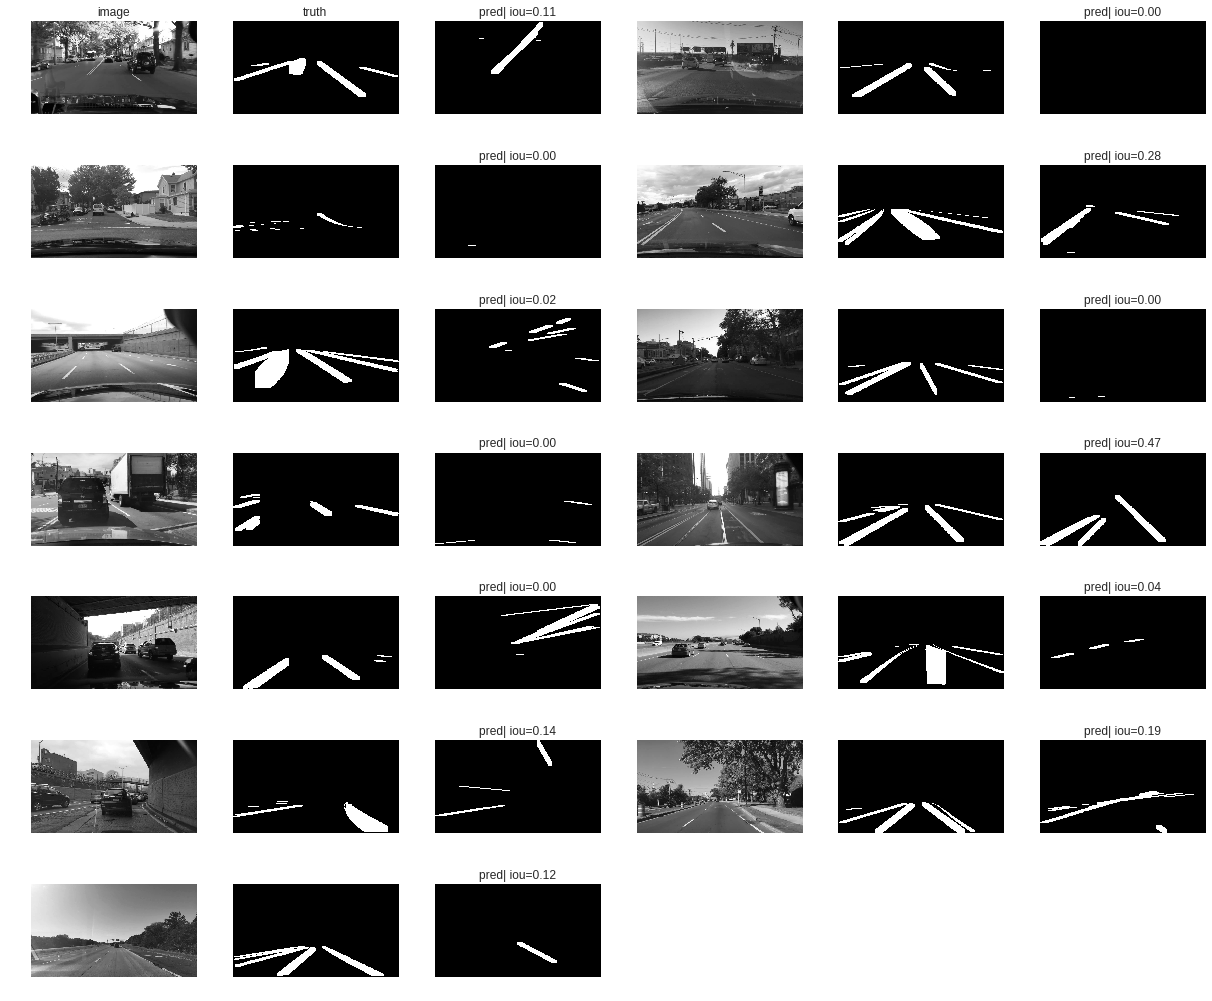

In [0]:
fig = plt.figure(figsize=(17,30))

npics=15
i=1
iou_d={}
for example in data10k_lanes_val[:npics]:
    
  iou_d = iou_d.copy()
  iou_d = comp_iou_wrapper(
            [example],
            gaussian_filter_sigma=best_params['gaussian_filter_sigma'],
            canny_min_threshold=int(best_params['canny_min_threshold']),
            canny_max_threshold=int(best_params['canny_max_threshold']),
            canny_aperture_size=int(best_params['canny_aperture_size']),
            canny_L2_gradient=best_params['canny_L2_gradient'],

            hough_rho=best_params['hough_rho'],
            hough_theta=best_params['hough_theta'],
            hough_threshold=int(best_params['hough_threshold']),
            hough_min_line_length=int(best_params['hough_min_line_length']),
            hough_max_line_gap=int(best_params['hough_max_line_gap']),

            evaluation_method=best_params['evaluation_method'],
            evaluation_box_diag=int(best_params['evaluation_box_diag'])
            )

  if len(iou_d) > 1:
    plt.subplot(npics,6,i)
    plt.imshow(iou_d['gray'],cmap='gray')
    plt.axis('off')
    if i <= 3 : plt.title('image')

    plt.subplot(npics,6,i+1)
    plt.imshow(iou_d['gt_box_2d'],cmap='gray')
    plt.axis('off')
    if i <= 3 : plt.title('truth')

    plt.subplot(npics,6,i+2)
    plt.imshow(iou_d['pred_box_2d'],cmap='gray')
    plt.axis('off')
    plt.title('pred| iou=%1.2f' % iou_d[example['name']])
    i+=3
  else: print('ERROR with %s' % example['name'])
plt.tight_layout()


## Conclusion
Looking at the ground truth labels, we see that the lane marking approach the horizon. Low IoU is caused by edges being predicted from non-lane markings. Many of these could be filtered out with a simple rule such as removing predictions in the top half / top quarter of the image.

It seems there is only so much juice we can squeeze out of the Canny/Hough approach. However perhaps the predictions could be passed on downstream into a data-driven method, which couuld learn robust ways of optimizing the IoU. The tried and true methods of digital image processing are a well developed tool box that can be mixed and matched in a given application and combined with data-driven methods.